## Data loading and parameters init

In [1]:
import os
import gc
import traceback
import numpy as np
import pandas as pd
import seaborn as sns
import gresearch_crypto
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
pd.set_option('display.max_columns', None)

In [2]:
DEVICE = "GPU" 
# DEVICE = "TPU" 

SEED = 42

EPOCHS = 10
DEBUG = True
N_ASSETS = 14
WINDOW_SIZE = 15
BATCH_SIZE = 1024
PCT_VALIDATION = 10 

In [3]:
if DEVICE == "TPU":
    print("Connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None
    if tpu:
        try:
            print("Initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except: print("Failed to initialize TPU")
    else: DEVICE = "GPU"

if DEVICE != "TPU": strategy = tf.distribute.get_strategy()
if DEVICE == "GPU": print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

Num GPUs Available:  1


2022-01-07 08:22:56.387003: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 08:22:56.493520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 08:22:56.494617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### Load additional data (Special version)

In [4]:
import datatable as dt
extra_data_files = {0: '../input/cryptocurrency-extra-data-binance-coin', 2: '../input/cryptocurrency-extra-data-bitcoin-cash', 1: '../input/cryptocurrency-extra-data-bitcoin', 3: '../input/cryptocurrency-extra-data-cardano', 4: '../input/cryptocurrency-extra-data-dogecoin', 5: '../input/cryptocurrency-extra-data-eos-io', 6: '../input/cryptocurrency-extra-data-ethereum', 7: '../input/cryptocurrency-extra-data-ethereum-classic', 8: '../input/cryptocurrency-extra-data-iota', 9: '../input/cryptocurrency-extra-data-litecoin', 11: '../input/cryptocurrency-extra-data-monero', 10: '../input/cryptocurrency-extra-data-maker', 12: '../input/cryptocurrency-extra-data-stellar', 13: '../input/cryptocurrency-extra-data-tron'}

orig_df_train = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_train.jay').to_pandas()
df_asset_details = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_asset_details.jay').to_pandas()
supp_df_train = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_supplemental_train.jay').to_pandas()
assets_details = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_asset_details.jay').to_pandas()
asset_weight_dict = {assets_details['Asset_ID'].tolist()[idx]: assets_details['Weight'].tolist()[idx] for idx in range(len(assets_details))}
asset_name_dict = {assets_details['Asset_ID'].tolist()[idx]: assets_details['Asset_Name'].tolist()[idx] for idx in range(len(assets_details))}

def load_training_data_for_asset(asset_id, load_jay = True):
    dfs = []
    if INCCOMP: dfs.append(orig_df_train[orig_df_train["Asset_ID"] == asset_id].copy())
    if INCSUPP: dfs.append(supp_df_train[supp_df_train["Asset_ID"] == asset_id].copy())
    
    if load_jay:
        if INC2017 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.jay').to_pandas())
        if INC2018 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.jay').to_pandas())
        if INC2019 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.jay').to_pandas())
        if INC2020 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.jay').to_pandas())
        if INC2021 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.jay').to_pandas())
    else: 
        if INC2017 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.csv'))
        if INC2018 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.csv'))
        if INC2019 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.csv'))
        if INC2020 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.csv'))
        if INC2021 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.csv'))
    df = pd.concat(dfs, axis = 0) if len(dfs) > 1 else dfs[0]
    df['date'] = pd.to_datetime(df['timestamp'], unit = 's')
    if LOAD_STRICT: df = df.loc[df['date'] < "2021-06-13 00:00:00"]    
    df = df.sort_values('date')
    return df

def load_data_for_all_assets():
    dfs = []
    for asset_id in list(extra_data_files.keys()): dfs.append(load_training_data_for_asset(asset_id))
    return pd.concat(dfs)

In [5]:
LOAD_STRICT = True

INC2021 = 0
INC2020 = 0
INC2019 = 0
INC2018 = 0
INC2017 = 0
INCCOMP = 1
INCSUPP = 0

train = load_data_for_all_assets().sort_values('timestamp').set_index("timestamp")
if DEBUG: train = train[10000000:]

test = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_example_test.jay').to_pandas()
sample_prediction_df = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_example_sample_submission.jay').to_pandas()
assets = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_asset_details.jay').to_pandas()
assets_order = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_supplemental_train.jay').to_pandas().Asset_ID[:N_ASSETS]
assets_order = dict((t,i) for i,t in enumerate(assets_order))
print("Loaded all data!")

Loaded all data!


### Reduce memory usage

In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name
        
        if col_type not in ['object', 'category', 'datetime64[ns, UTC]', 'datetime64[ns]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


## Additional features

MAX COMBO VERSION (no enough memory :))

In [7]:
def upper_shadow(df): return df['High'] - np.maximum(df['Close'], df['Open'])
def lower_shadow(df): return np.minimum(df['Close'], df['Open']) - df['Low']

def get_features(df, row = False):
    df_feat = df
    df_feat['spread'] = df_feat['High'] - df_feat['Low']
    df_feat['mean_trade'] = df_feat['Volume']/df_feat['Count']
    df_feat['log_price_change'] = np.log(df_feat['Close']/df_feat['Open'])
    df_feat['upper_Shadow'] = upper_shadow(df_feat)
    # df_feat['lower_Shadow'] = lower_shadow(df_feat)
    df_feat["high_div_low"] = df_feat["High"] / df_feat["Low"]
    df_feat['trade'] = df_feat['Close'] - df_feat['Open']
    #df_feat['gtrade'] = df_feat['trade'] / df_feat['Count']
    df_feat['shadow1'] = df_feat['trade'] / df_feat['Volume']
    # df_feat['shadow3'] = df_feat['upper_Shadow'] / df_feat['Volume']
    #df_feat['shadow5'] = df_feat['lower_Shadow'] / df_feat['Volume']
    df_feat['diff1'] = df_feat['Volume'] - df_feat['Count']
    # df_feat['mean1'] = (df_feat['shadow5'] + df_feat['shadow3']) / 2
    df_feat['mean2'] = (df_feat['shadow1'] + df_feat['Volume']) / 2
    #df_feat['mean3'] = (df_feat['trade'] + df_feat['gtrade']) / 2
    #df_feat['mean4'] = (df_feat['diff1'] + df_feat['upper_Shadow']) / 2
    # df_feat['mean5'] = (df_feat['diff1'] + df_feat['lower_Shadow']) / 2
    df_feat['UPS'] = (df_feat['High'] - np.maximum(df_feat['Close'], df_feat['Open']))
    #df_feat['UPS'] = df_feat['UPS']
    df_feat['LOS'] = (np.minimum(df_feat['Close'], df_feat['Open']) - df_feat['Low'])
    # df_feat['LOS'] = df_feat['LOS']
    df_feat['RNG'] = ((df_feat['High'] - df_feat['Low']) / df_feat['VWAP'])
    #df_feat['RNG'] = df_feat['RNG']
    # df_feat['MOV'] = ((df_feat['Close'] - df_feat['Open']) / df_feat['VWAP'])
    # df_feat['MOV'] = df_feat['MOV']
    df_feat['CLS'] = ((df_feat['Close'] - df_feat['VWAP']) / df_feat['VWAP'])
    #df_feat['CLS'] = df_feat['CLS']
    df_feat['LOGVOL'] = np.log(1. + df_feat['Volume'])
    #df_feat['LOGVOL'] = df_feat['LOGVOL']
    df_feat['LOGCNT'] = np.log(1. + df_feat['Count'])
    df_feat['LOGCNT'] = df_feat['LOGCNT']
    df_feat["Close/Open"] = df_feat["Close"] / df_feat["Open"]
    df_feat["Close-Open"] = df_feat["Close"] - df_feat["Open"]
    df_feat["High-Low"] = df_feat["High"] - df_feat["Low"]
    df_feat["High/Low"] = df_feat["High"] / df_feat["Low"]
    if row: df_feat['Mean'] = df_feat[['Open', 'High', 'Low', 'Close']].mean()
    else: df_feat['Mean'] = df_feat[['Open', 'High', 'Low', 'Close']].mean(axis = 1)
    #df_feat["High/Mean"] = df_feat["High"] / df_feat["Mean"]
    df_feat["Low/Mean"] = df_feat["Low"] / df_feat["Mean"]
    df_feat["Volume/Count"] = df_feat["Volume"] / (df_feat["Count"] + 1)
    mean_price = df_feat[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    median_price = df_feat[['Open', 'High', 'Low', 'Close']].median(axis=1)
    #df_feat['high2mean'] = df_feat['High'] / mean_price
    df_feat['low2mean'] = df_feat['Low'] / mean_price
    df_feat['high2median'] = df_feat['High'] / median_price
    #df_feat['low2median'] = df_feat['Low'] / median_price
    # df_feat['volume2count'] = df_feat['Volume'] / (df_feat['Count'] + 1)
    return df_feat

train[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target']] = train[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target']].astype(np.float32)
print(train.shape)
train['Target'] = train['Target'].fillna(0)
VWAP_max = np.max(train[np.isfinite(train.VWAP)].VWAP)
VWAP_min = np.min(train[np.isfinite(train.VWAP)].VWAP)
train['VWAP'] = np.nan_to_num(train.VWAP, posinf=VWAP_max, neginf=VWAP_min)
df = train[['Asset_ID', 'Target']].copy()
times = dict((t,i) for i,t in enumerate(df.index.unique()))
df['id'] = df.index.map(times)
df['id'] = df['id'].astype(str) + '_' + df['Asset_ID'].astype(str)
ids = df.id.copy()
del df
train = get_features(train)
train_features = [i for i in train.columns if i not in ['Target', 'date', 'timestamp', 'Asset_ID', 'groups']]

(12221694, 10)


In [8]:
train = train.sort_index()
ind = train.index.unique()
def reindex(df):
    df = df.reindex(range(ind[0],ind[-1]+60,60),method='nearest')
    df = df.fillna(method="ffill").fillna(method="bfill")
    return df
train = train.groupby('Asset_ID').apply(reindex).reset_index(0, drop=True).sort_index()
gc.collect()
train.shape

(12962516, 34)

In [9]:
train['group_num'] = train.index.map(times)
train = train.dropna(subset=['group_num'])
train['group_num'] = train['group_num'].astype('int')
train['id'] = train['group_num'].astype(str) + '_' + train['Asset_ID'].astype(str)
train['is_real'] = train.id.isin(ids) * 1
train = train.drop('id', axis=1)

In [10]:
features = train.columns.drop(['Asset_ID','group_num','is_real'])
train.loc[train.is_real == 0, features] = 0.

In [11]:
train['asset_order'] = train.Asset_ID.map(assets_order)
train = train.sort_values(by=['group_num', 'asset_order'])
train = reduce_mem_usage(train)
train.head(20)
gc.collect()

Memory usage of dataframe is 2274.23 MB
Memory usage after optimization is: 1409.03 MB
Decreased by 38.0%


0

## Data split

In [12]:
targets = train['Target'].to_numpy().reshape(-1, N_ASSETS)
features = train.columns.drop(['Asset_ID', 'Target', 'group_num', 'is_real', 'date'])
train = train[features]
train = train.values
train = train.reshape(-1, N_ASSETS, train.shape[-1])

In [13]:
class sample_generator(keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size, length):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.length = length
        self.size = len(x_set)
    def __len__(self): return int(np.ceil(len(self.x) / float(self.batch_size)))
    def __getitem__(self, idx):
        batch_x=[]
        batch_y=[]
        for i in range(self.batch_size):
            start_ind = self.batch_size*idx + i
            end_ind = start_ind + self.length 
            if end_ind <= self.size:
                batch_x.append(self.x[start_ind : end_ind])
                batch_y.append(self.y[end_ind -1])
        return np.array(batch_x), np.array(batch_y)

In [14]:
X_train, X_test = train[:-len(train)//PCT_VALIDATION], train[-len(train)//PCT_VALIDATION:]
y_train, y_test = targets[:-len(train)//PCT_VALIDATION], targets[-len(train)//PCT_VALIDATION:]

In [15]:
train_generator = sample_generator(X_train, y_train, length = WINDOW_SIZE, batch_size = BATCH_SIZE)
val_generator = sample_generator(X_test, y_test, length = WINDOW_SIZE, batch_size = BATCH_SIZE)

## Getting model

In [16]:
def MaxCorrelation(y_true,y_pred): return -tf.math.abs(tfp.stats.correlation(y_pred,y_true, sample_axis=None, event_axis=None))
def Correlation(y_true,y_pred): return tf.math.abs(tfp.stats.correlation(y_pred,y_true, sample_axis=None, event_axis=None))

def masked_mse(y_true, y_pred):
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.keras.losses.mean_squared_error(y_true = y_true_masked, y_pred = y_pred_masked)

def masked_mae(y_true, y_pred):
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.keras.losses.mean_absolute_error(y_true = y_true_masked, y_pred = y_pred_masked)

def masked_cosine(y_true, y_pred):
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.keras.losses.cosine_similarity(y_true_masked, y_pred_masked)

def get_squence_model(x):
    x = layers.LSTM(units=32, return_sequences=True)(x)
    return x

def get_model(n_assets = 14):
    x_input = keras.Input(shape=(train_generator[0][0].shape[1], n_assets, train_generator[0][0].shape[-1]))
    branch_outputs = []
    for i in range(n_assets):
        a = layers.Lambda(lambda x: x[:,:, i])(x_input) # Slicing the ith asset:
        a = layers.Masking(mask_value = 0., )(a)
        a = get_squence_model(a)
        a = layers.GlobalAvgPool1D()(a)
        branch_outputs.append(a)
    x = layers.Concatenate()(branch_outputs)
    x = layers.Dense(units = 128)(x)
    out = layers.Dense(units = n_assets)(x)
    model = keras.Model(inputs=x_input, outputs=out)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), loss = masked_cosine, metrics=[Correlation])
    return model
    
model = get_model()
model.summary()

2022-01-07 08:26:50.289608: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-07 08:26:50.292534: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 08:26:50.293387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 08:26:50.294085: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 14, 32)] 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 15, 32)       0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 15, 32)       0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 15, 32)       0           input_1[0][0]                    
______________________________________________________________________________________________

2022-01-07 08:27:03.177118: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).


2022-01-07 08:27:41.424069: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


814/814 [==============================] - 146s 124ms/step - loss: -0.0033 - Correlation: 0.0214 - val_loss: 0.0015 - val_Correlation: 0.0225
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009831635, shape=(), dtype=float32).
814/814 [==============================] - 88s 108ms/step - loss: -0.0063 - Correlation: 0.0226 - val_loss: -0.0028 - val_Correlation: 0.0230
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.00096661027, shape=(), dtype=float32).
814/814 [==============================] - 85s 105ms/step - loss: -0.0078 - Correlation: 0.0250 - val_loss: -0.0038 - val_Correlation: 0.0284
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00095033593, shape=(), dtype=float32).
814/814 [==============================] - 90s 111ms/step - loss: -0.0082 - Correlation: 0.0246 - val_loss: -0.0028 - val_Correlation: 0.0247
Epoch 5/10

Epoch 00005: LearningRateScheduler setting learning 

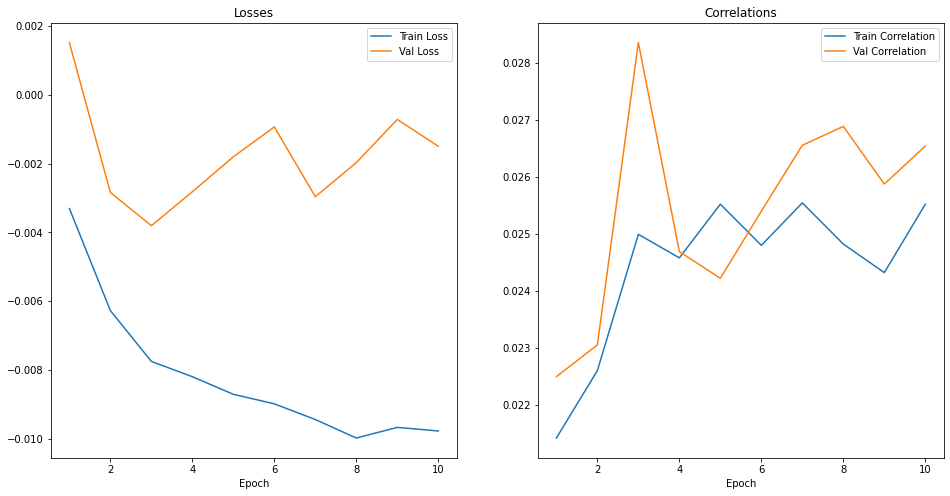

In [17]:
tf.random.set_seed(0)
estop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 7, verbose = 0, mode = 'min',restore_best_weights = True)
scheduler = keras.optimizers.schedules.ExponentialDecay(1e-3, (0.5 * len(X_train) / BATCH_SIZE), 1e-3)
lr = keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
history = model.fit(train_generator, validation_data = (val_generator), epochs = EPOCHS, callbacks = [lr, estop])

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
histories = pd.DataFrame(history.history)
epochs = list(range(1,len(histories)+1))
loss = histories['loss']
val_loss = histories['val_loss']
Correlation = histories['Correlation']
val_Correlation = histories['val_Correlation']
ax[0].plot(epochs, loss, label = 'Train Loss')
ax[0].plot(epochs, val_loss, label = 'Val Loss')
ax[0].set_title('Losses')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='upper right')
ax[1].plot(epochs, Correlation, label = 'Train Correlation')
ax[1].plot(epochs, val_Correlation, label = 'Val Correlation')
ax[1].set_title('Correlations')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='upper right')
fig.show()
gc.collect()

# The correlation coefficients by asset for the validation data
predictions = model.predict(val_generator)

print('Asset:    Corr. coef.')
print('---------------------')
for i in range(N_ASSETS):
    # drop first 14 values in the y_test, since they are absent in val_generator labels
    y_true = np.squeeze(y_test[WINDOW_SIZE - 1:, i])
    y_pred = np.squeeze(predictions[:, i])
    real_target_ind = np.argwhere(y_true!=0)
    asset_id = list(assets_order.keys())[i]
    asset_name = assets[assets.Asset_ID == asset_id]['Asset_Name'].item()
    print(f"{asset_name}: {np.corrcoef(y_pred[real_target_ind].flatten(), y_true[real_target_ind].flatten())[0,1]:.4f}")

In [18]:
sup = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_supplemental_train.jay').to_pandas()[:WINDOW_SIZE * (N_ASSETS)]
placeholder = get_features(sup)
placeholder['asset_order'] = placeholder.Asset_ID.map(assets_order)
test_sample = np.array(placeholder[features])
test_sample = test_sample.reshape(-1, (N_ASSETS), test_sample.shape[-1])
test_sample = np.expand_dims(test_sample, axis=0)

In [19]:
example = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_example_test.jay').to_pandas()[:WINDOW_SIZE - 1]
example['asset_order'] = example.Asset_ID.map(assets_order) 
example = example[['Asset_ID','asset_order']]

## Kaggle submit

In [20]:
env = gresearch_crypto.make_env()
iter_test = env.iter_test()

for (test_df, sample_prediction_df) in iter_test:
    test_df = get_features(test_df)
    test_data = test_df.merge(example, how='outer', on='Asset_ID').sort_values('asset_order')
    test = np.array(test_data[features].fillna(0))
    test = test.reshape(-1, 1, N_ASSETS, test.shape[-1])
    test_sample = np.hstack([test_sample, test])[:,-1 * WINDOW_SIZE:]
    y_pred = model.predict(test_sample).squeeze().reshape(-1, 1).squeeze()
    test_data['Target'] = y_pred
    for _, row in test_df.iterrows():
        try: sample_prediction_df.loc[sample_prediction_df['row_id'] == row['row_id'], 'Target'] = test_data.loc[test_data['row_id'] == row['row_id'], 'Target'].item()
        except: sample_prediction_df.loc[sample_prediction_df['row_id'] == row['row_id'], 'Target'] = 0
    env.predict(sample_prediction_df)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


<br>

## Public score

0.0037